# Clustering mask data

In [78]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import uns

Extract samples with large mask area

In [6]:
masks = training[training['maskArea']>1]


Mask data array will have the following properties:
area, c1, c2, s1, s2, theta, (perimeter?)



In [57]:
maskdata = np.zeros((len(masks),7))
for idx, row in enumerate(masks.iterrows()):
    V = row[1]['maskV']
    angle = np.arctan(V[0,1]/V[1,1])
    perimeter = row[1]['maskContour'].shape[0]
    maskdata[idx,:] = [row[1]['maskArea'],
                       row[1]['maskC'][0],
                       row[1]['maskC'][1],
                       row[1]['maskS'][0],
                       row[1]['maskS'][1],
                       np.arctan(V[1,0]/V[0,0]),
                       perimeter]

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#X = StandardScaler().fit_transform(maskdata)
X = maskdata/np.max(abs(maskdata),axis=0)
pca = PCA(n_components=0.95)
pca.fit(X)
pca.explained_variance_ratio_

array([ 0.68006332,  0.19039546,  0.059853  ,  0.04039271])

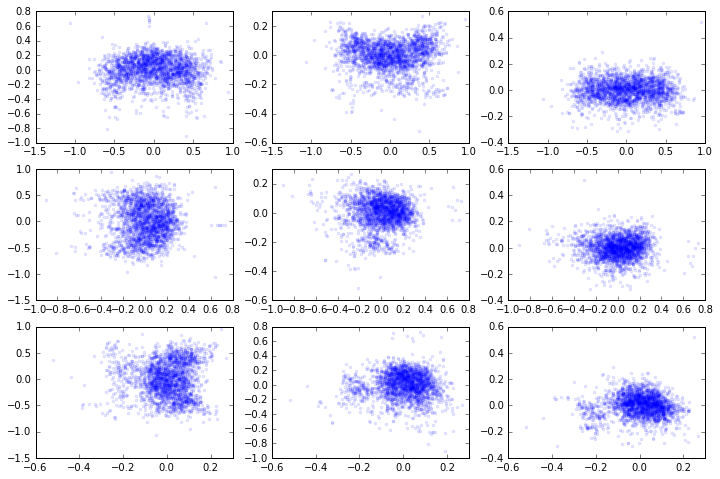

In [183]:
P = pca.fit_transform(X)
ncomp = 4
comps = np.arange(ncomp)
fig, ax = plt.subplots(ncomp-1,ncomp-1,figsize=(12,8))
for xcomp, row in enumerate(ax):
    ycomp = np.delete(comps,xcomp)
    for j, axs in enumerate(row):
        axs.plot(P[:,xcomp],P[:,ycomp[j]],'.', alpha=0.1)

## DBSCAN clustering
Following http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#example-cluster-plot-dbscan-py

In [219]:
from sklearn import cluster

db = cluster.DBSCAN(eps=0.5).fit(X)
#db = cluster.Birch(threshold=0.1,n_clusters=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

In [220]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


/Users/chrisv/anaconda/lib/python3.4/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


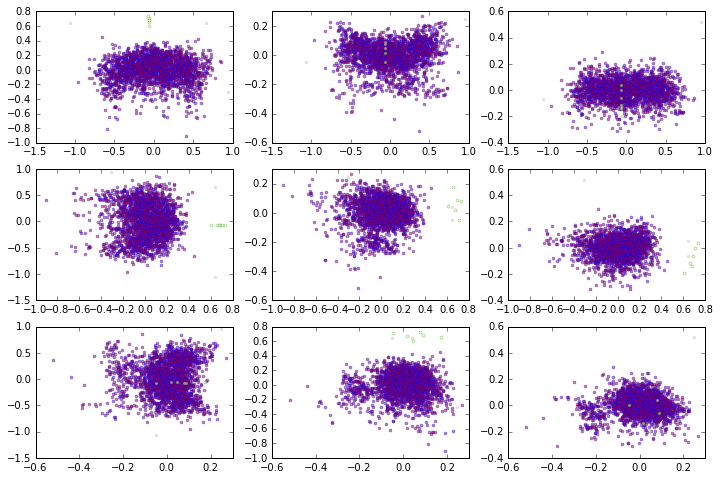

In [221]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
ncomp = 4
comps = np.arange(ncomp)
fig, ax = plt.subplots(ncomp-1,ncomp-1,figsize=(12,8))
P = pca.fit_transform(X)
for k, col in zip(unique_labels, colors):
    alpha = 0.5
    if k == -1:
        # Black used for noise.
        alpha = 0.1
        col = 'k'

    class_member_mask = (labels == k)
    
    p = P[class_member_mask]
    for xcomp, row in enumerate(ax):
        ycomp = np.delete(comps,xcomp)
        for j, axs in enumerate(row):
            axs.plot(p[:,xcomp],p[:,ycomp[j]],'.',markerfacecolor=col, alpha=alpha)
    
plt.show()